# Проект: классификация

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from  sklearn.ensemble import IsolationForest
import warnings
warnings.filterwarnings('ignore')
from sklearn.preprocessing  import LabelEncoder
from sklearn import linear_model 
from sklearn import tree 
from sklearn import ensemble 
from sklearn import metrics 
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split 
from sklearn.feature_selection import SelectKBest, f_classif

## Часть 1. Знакомство с данными, обработка пропусков и выбросов

Данные о клиентах банка:

age (возраст);

job (сфера занятости);

marital (семейное положение);

education (уровень образования);

default (имеется ли просроченный кредит);

housing (имеется ли кредит на жильё);

loan (имеется ли кредит на личные нужды);

balance (баланс).


Данные, связанные с последним контактом в контексте текущей маркетинговой кампании:

contact (тип контакта с клиентом);

month (месяц, в котором был последний контакт);

day (день, в который был последний контакт);

duration (продолжительность контакта в секундах).


Прочие признаки:

campaign (количество контактов с этим клиентом в течение текущей кампании);

pdays (количество пропущенных дней с момента последней маркетинговой кампании до контакта в текущей кампании);

previous (количество контактов до текущей кампании)

poutcome (результат прошлой маркетинговой кампании).

И, разумеется, наша целевая переменная deposit, которая определяет, согласится ли клиент открыть депозит в банке. Именно её мы будем пытаться предсказать в данном кейсе.

### Задание 1

In [2]:
df = pd.read_csv('bank_fin.csv', sep = ';')

In [86]:
df.head(3)

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes


In [3]:
# исследуйте данные на предмет пропусков. Где есть пропущенные значения? Сколько их?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11162 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        11162 non-null  int64 
 1   job        11162 non-null  object
 2   marital    11162 non-null  object
 3   education  11162 non-null  object
 4   default    11162 non-null  object
 5   balance    11137 non-null  object
 6   housing    11162 non-null  object
 7   loan       11162 non-null  object
 8   contact    11162 non-null  object
 9   day        11162 non-null  int64 
 10  month      11162 non-null  object
 11  duration   11162 non-null  int64 
 12  campaign   11162 non-null  int64 
 13  pdays      11162 non-null  int64 
 14  previous   11162 non-null  int64 
 15  poutcome   11162 non-null  object
 16  deposit    11162 non-null  object
dtypes: int64(6), object(11)
memory usage: 1.4+ MB


In [4]:
df.isnull().sum()

age           0
job           0
marital       0
education     0
default       0
balance      25
housing       0
loan          0
contact       0
day           0
month         0
duration      0
campaign      0
pdays         0
previous      0
poutcome      0
deposit       0
dtype: int64

Пропущенные значения в признаке balance = 25

### Задание 2

In [5]:
# есть ли в признаке job пропущенные значения? Возможно, они обозначены каким-то специальным словом?
df['job'].value_counts()

management       2566
blue-collar      1944
technician       1823
admin.           1334
services          923
retired           778
self-employed     405
student           360
unemployed        357
entrepreneur      328
housemaid         274
unknown            70
Name: job, dtype: int64

В признаке job пропущенные значения обозначены unknown = 70

### Задание 3

In [38]:
# преобразуйте признак balance таким образом, чтобы он корректно считывался, как вещественное число (float)
# спользуйте метод replace(), с помощью которого вы сможете убрать ненужные нули с запятой, 
# знак доллара и пробелы. Затем необходимо преобразовать данные в тип float с помощью метода astype().

def make_convert(row):
    row = str(row)
    if row != 'unknown':
        row = row.replace(',00', '')
        row = row.replace('$', '')
        row = row.replace(' ', '')
        return float(row)
    else:
        return np.nan
    
df['balance'] = df['balance'].apply(make_convert)

round(df['balance'].mean(),3)

### Задание 4

In [46]:
# обработайте пропуски в признаки balance , заменив их на медианные значения по данному признаку

df['balance'] = df['balance'].fillna(df['balance'].median())
round(df['balance'].mean(),3)

### Задание 5

In [65]:
# обработайте пропуски в категориальных признаках: job и education, заменив их на модальные значения

m_job = df['job'].mode()[0]
df['job'] = df['job'].apply(lambda x: m_job if x == 'unknown' else x)

m_education = df['education'].mode()[0]
df['education'] = df['education'].apply(lambda x: m_education if x == 'unknown' else x)

#После замены пропусков рассчитайте средний баланс для клиентов с самой популярной работой и самым популярным уровнем образования
#(т. е. для тех, у кого одновременно самая популярная работа и самое популярное образование). 
# Ответ округлите до трёх знаков после точки-разделителя.

mask = (df['job'] == df['job'].value_counts().index[0]) & (df['education'] == df['education'].value_counts().index[0])
df['balance'][mask].mean().round(3)

### Задание 6

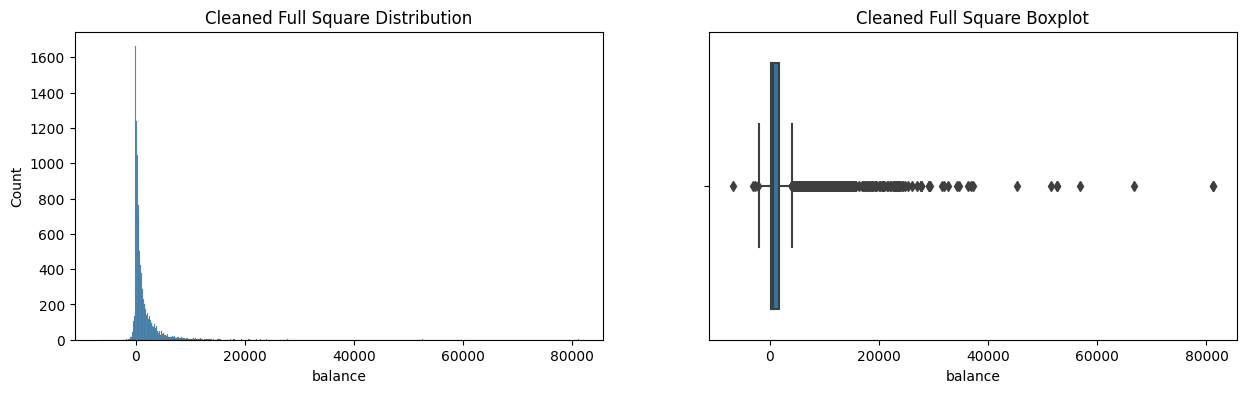

In [74]:
# удалите все выбросы для признака balance

#исходное распределение признака
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=df, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=df, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

Число выбросов по методу Тьюки: 1057
Результирующее число записей: 10105


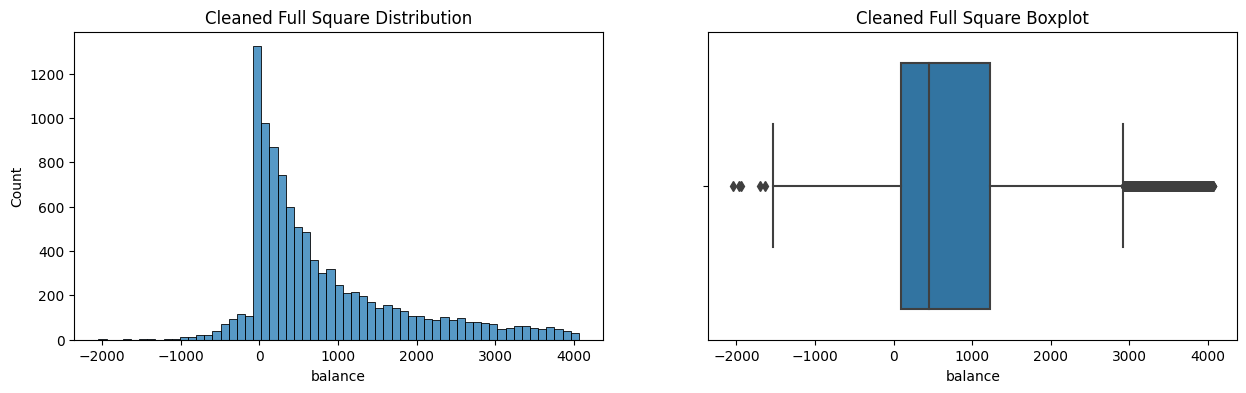

In [83]:
#функция для очистки от выбросов по методу Тьюки

def outliers_iqr_mod(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    outliers = data[(x<lower_bound) | (x> upper_bound)]
    cleaned = data[(x>lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

#применение функции, вывод результатов
outliers, cleaned = outliers_iqr_mod(df, 'balance')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

#распределение признака после очистки от выбросов
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=cleaned, x='balance', ax=axes[0]);
histplot.set_title('Cleaned Full Square Distribution');
boxplot = sns.boxplot(data=cleaned, x='balance', ax=axes[1]);
boxplot.set_title('Cleaned Full Square Boxplot');

In [84]:
# Введите верхнюю и нижнюю границы поиска выбросов по методу Тьюки, округлив их до целых чисел.

def bound(data, feature, left=1.5, right=1.5):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * left)
    upper_bound = quartile_3 + (iqr * right)
    return lower_bound, upper_bound

print(bound(df, 'balance'))

(-2241.0, 4063.0)


In [92]:
#Сколько объектов осталось после удаления всех выбросов?
cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10105 entries, 0 to 11161
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        10105 non-null  int64  
 1   job        10105 non-null  object 
 2   marital    10105 non-null  object 
 3   education  10105 non-null  object 
 4   default    10105 non-null  object 
 5   balance    10105 non-null  float64
 6   housing    10105 non-null  object 
 7   loan       10105 non-null  object 
 8   contact    10105 non-null  object 
 9   day        10105 non-null  int64  
 10  month      10105 non-null  object 
 11  duration   10105 non-null  int64  
 12  campaign   10105 non-null  int64  
 13  pdays      10105 non-null  int64  
 14  previous   10105 non-null  int64  
 15  poutcome   10105 non-null  object 
 16  deposit    10105 non-null  object 
dtypes: float64(1), int64(6), object(10)
memory usage: 1.4+ MB


## Часть 2:  Разведывательный анализ

### Задание 1

In [93]:
cleaned['deposit'].value_counts()

no     5424
yes    4681
Name: deposit, dtype: int64

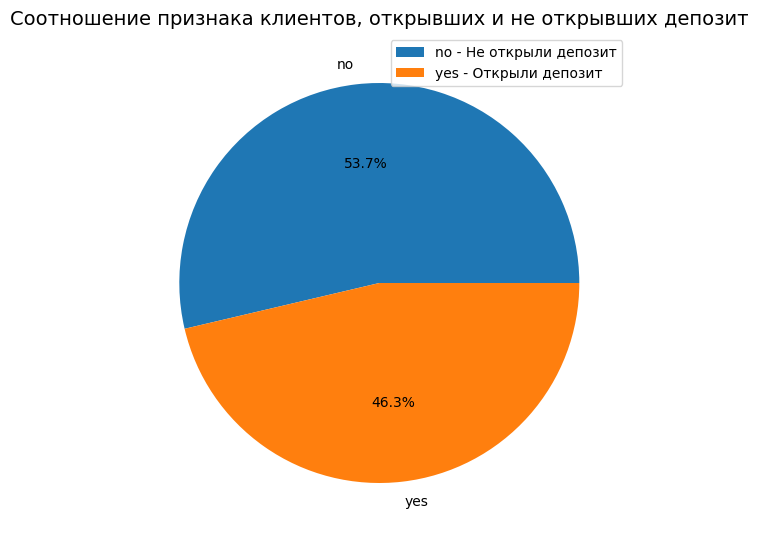

In [94]:
# изучите соотношение классов в ваших данных на предмет несбалансированности, проиллюстрируйте результат

exited_df = cleaned['deposit'].value_counts()
fig = plt.figure(figsize=(5, 5))
axes = fig.add_axes([0, 0, 1, 1])
axes.pie(
    exited_df,
    labels= exited_df.index,
    autopct='%.1f%%',
    explode = [0, 0]
    #установка параметров отображения
)
axes.set_title('Соотношение признака клиентов, открывших и не открывших депозит', fontsize=14)
axes.legend(['no - Не открыли депозит', 'yes - Открыли депозит']);

# ВЫВОД: данные сбалансированы



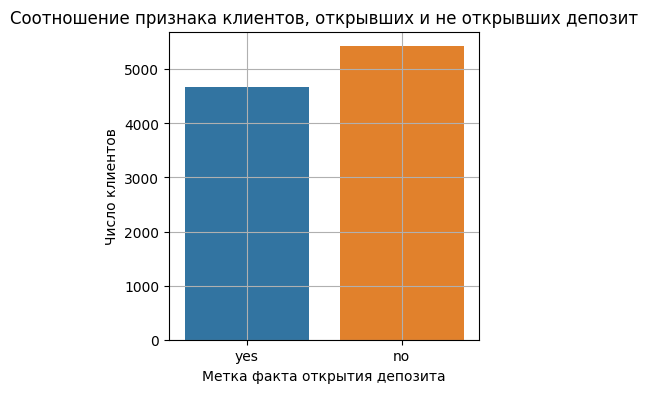

In [96]:
fig = plt.figure(figsize=(4, 4))

countplot = sns.countplot(data=cleaned, x="deposit")
countplot.set_title('Соотношение признака клиентов, открывших и не открывших депозит');
countplot.set_xlabel('Метка факта открытия депозита');
countplot.set_ylabel('Число клиентов');
countplot.grid();



### Задания 2 и 3

Начнём с описательных статистик для количественных переменных.

 - Рассчитайте их и продумайте подробную интерпретацию.

 - Попробуйте описать данные, которые у вас есть, увидеть первые зависимости.

 - Рассмотрите минимальные и максимальные значения.

 - Посмотрите на меры разброса и оцените, насколько данные вариативны.

 - Сравнив меры центральной тенденции, сделайте выводы о том, есть ли аномальные значения с меньшей или большей стороны.

 - Дополните выводы визуализациями. Вспомните, какие диаграммы могут помочь в иллюстрации распределений количественных данных.

In [102]:
#рассчитайте описательные статистики для количественных переменных, проинтерпретируйте результат

cleaned.describe()

,age,balance,day,duration,campaign,pdays,previous
count,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000,10105.000000
mean,40.895497,807.653538,15.590302,368.742603,2.517170,51.319644,0.816230
std,11.734931,994.151966,8.441510,346.651524,2.707159,109.644179,2.243795
min,18.000000,-2049.000000,1.000000,2.000000,1.000000,-1.000000,0.000000
25%,32.000000,95.000000,8.000000,137.000000,1.000000,-1.000000,0.000000
50%,38.000000,445.000000,15.000000,252.000000,2.000000,-1.000000,0.000000
75%,48.000000,1227.000000,22.000000,490.000000,3.000000,2.000000,1.000000
max,95.000000,4063.000000,31.000000,3881.000000,43.000000,854.000000,58.000000


Количественные переменные:

- AGE - минимульный 18 лет, максимальный 95 лет, средний 40 лет. По графику - большинсвто значений около 35. 
- BALANCE - Стандартное отклонение 994 , следовательно разброс большой. Есть отрицательные и положительные значение. Среднее = 807, Мах = 4063, Мин = -2049. По графику - большинсвто значений около 0. 
- DAY - мин 1, макс 31, среднее 8.По графику распределенны почти равномерно, без особенностей. Значит непонятно чем руководствуются при выборе интервала звонка
- DURATION - мин 2, макс 3881 сек (около 60 минут, возможно выброс?), среднее 368 секунд (около 6 минут)
- CAMPAING 
- PDAYS
- PREVIOUS
В последний трех признаков большинство данных сгруппированы в начале оси X, однако есть единичные, которые значительно отличаются от большинсва

<Figure size 640x480 with 0 Axes>

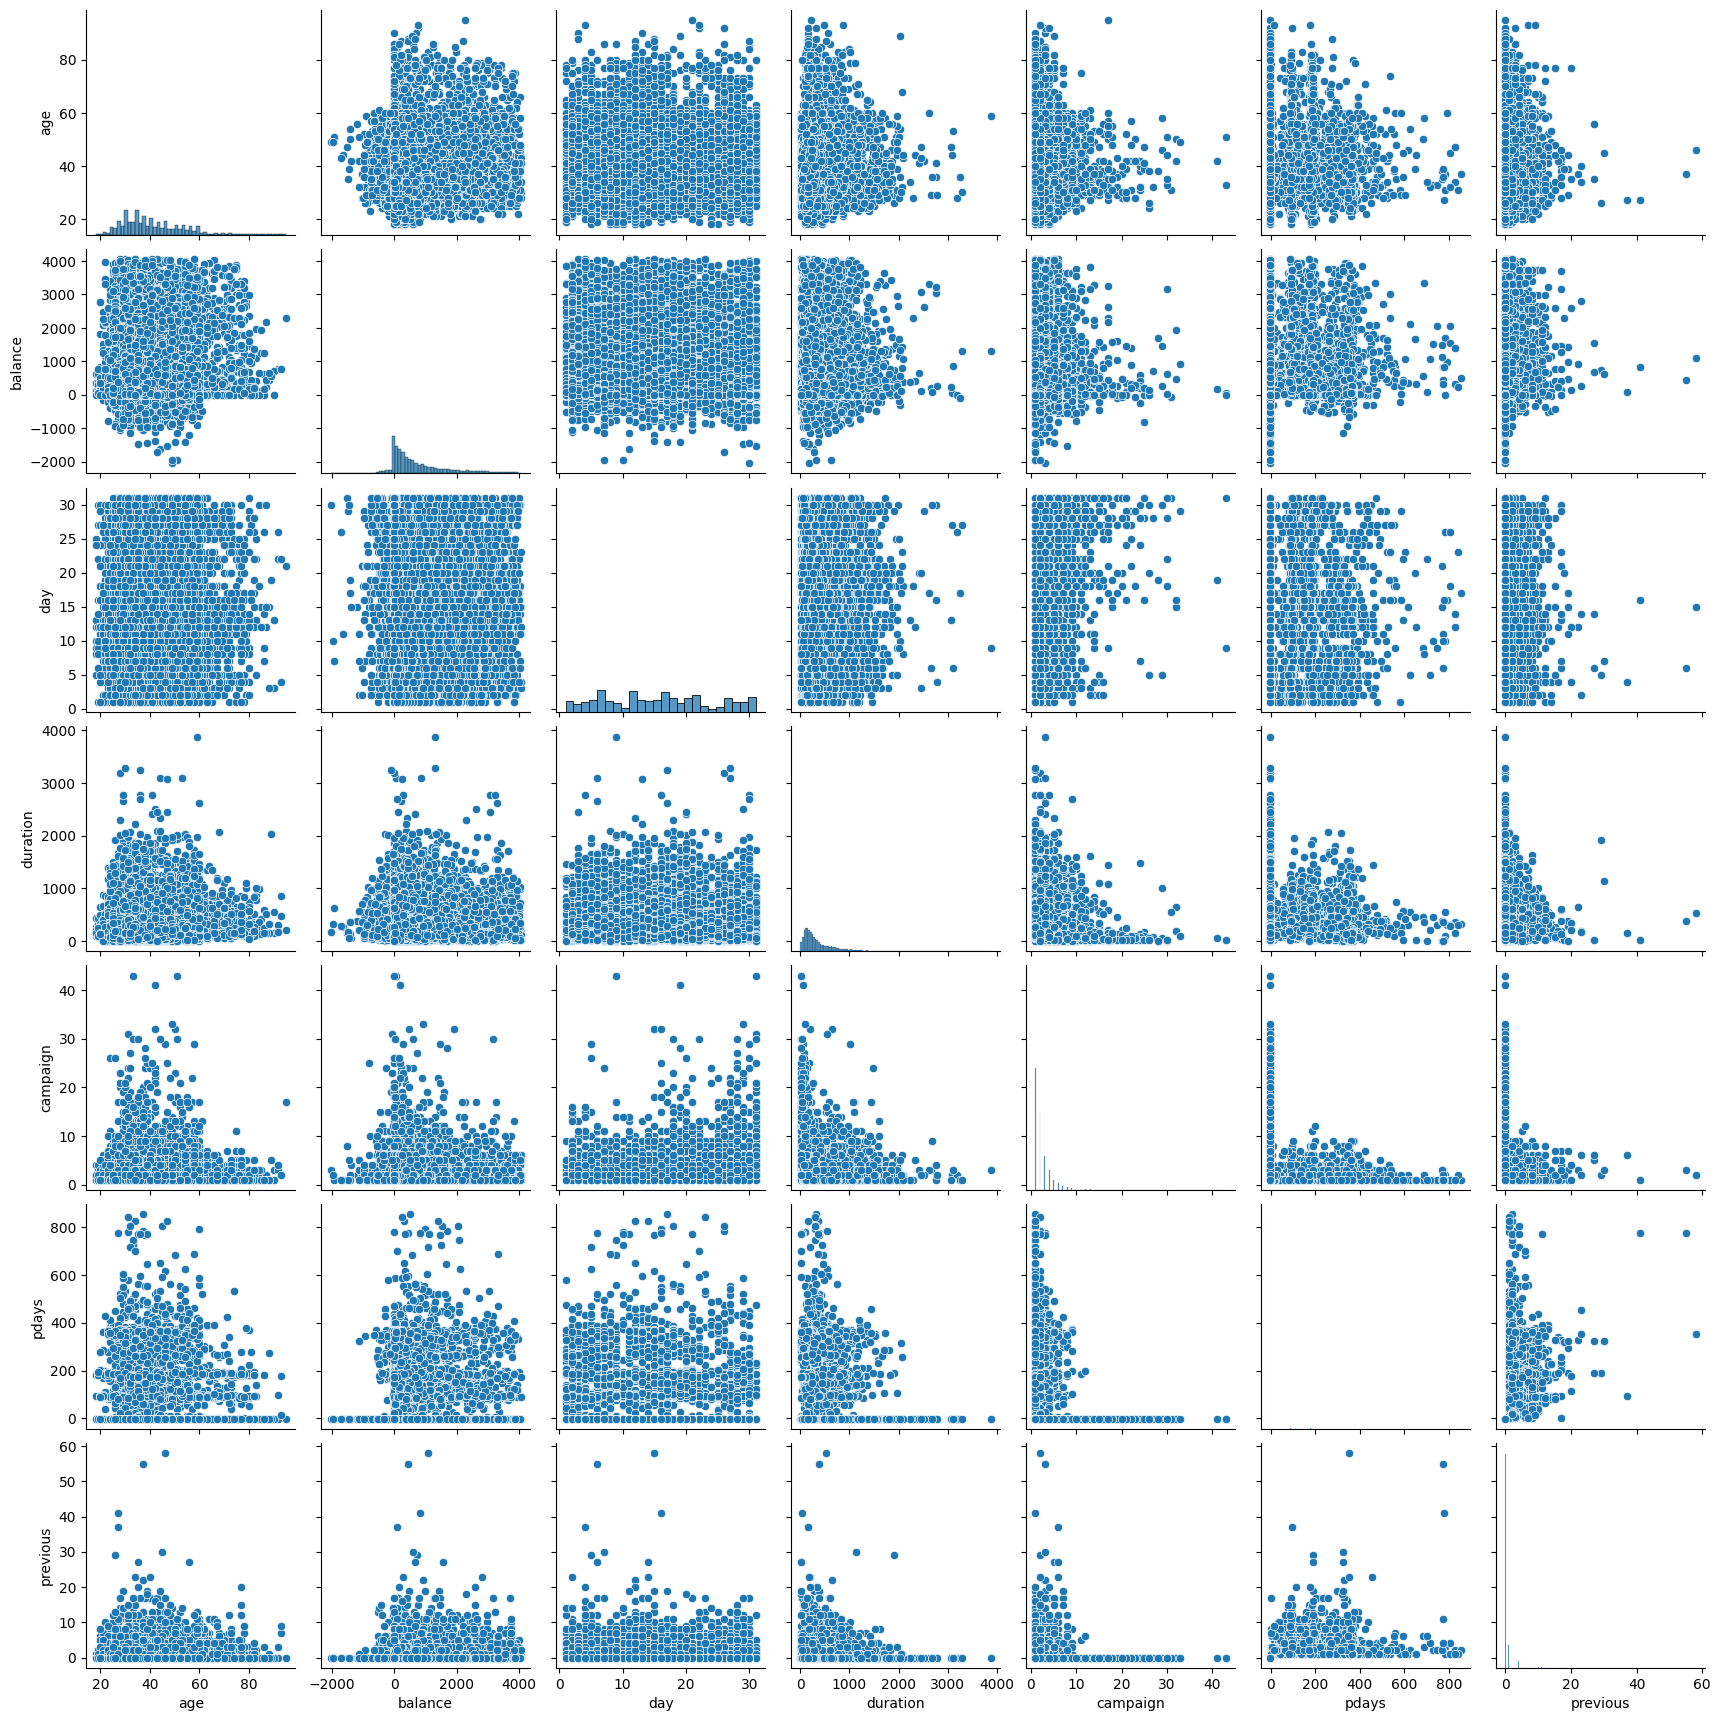

In [104]:
to_plot = ["age", "balance", "day", "duration", "campaign", "pdays", 'previous' ]
plt.figure()
sns.pairplot(cleaned[to_plot])
plt.show()

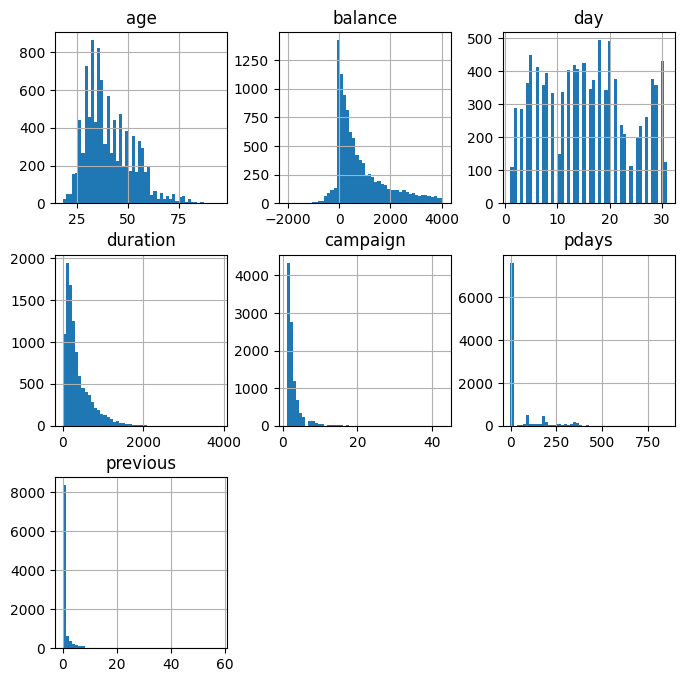

In [109]:
cleaned.hist(bins=50, figsize=(8, 8))
plt.show()

### Задания 4 и 5

In [110]:
#рассчитайте описательные статистики для категориальных переменных, проинтерпретируйте результат
cleaned.describe(include= 'object')

,job,marital,education,default,housing,loan,contact,month,poutcome,deposit
count,10105,10105,10105,10105,10105,10105,10105,10105,10105,10105
unique,11,3,3,2,2,2,3,12,4,2
top,management,married,secondary,no,no,no,cellular,may,unknown,no
freq,2315,5715,5517,9939,5243,8712,7283,2617,7570,5424


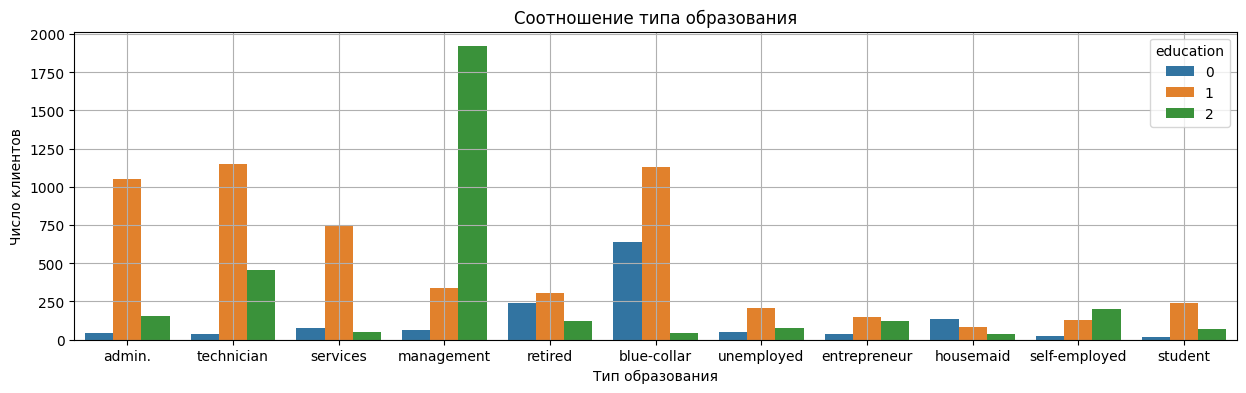

In [318]:
fig = plt.figure(figsize=(15, 4))
countplot = sns.countplot(data=cleaned, x="job", hue= 'education')
countplot.set_title('Соотношение типа образования');
countplot.set_xlabel('Тип образования');
countplot.set_ylabel('Число клиентов');
countplot.grid();

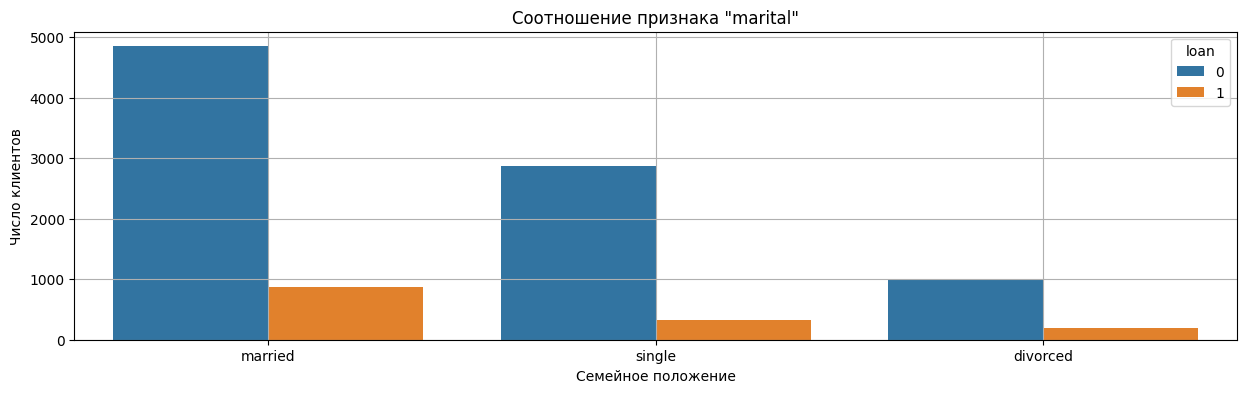

In [320]:
fig = plt.figure(figsize=(15, 4))

countplot = sns.countplot(data=cleaned, x="marital", hue= 'loan')
countplot.set_title('Соотношение признака "marital"');
countplot.set_xlabel('Семейное положение');
countplot.set_ylabel('Число клиентов');
countplot.grid();

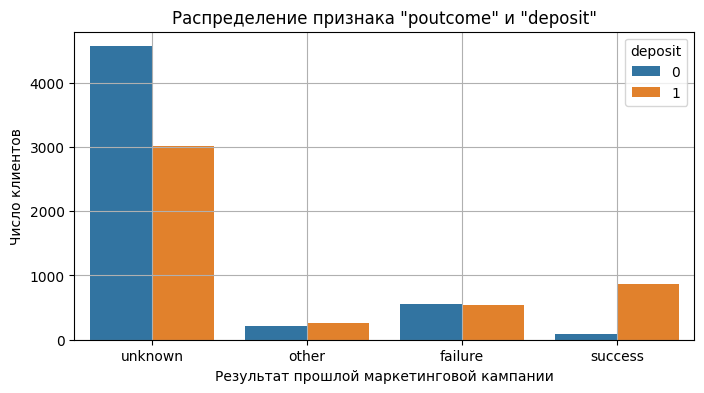

In [321]:
fig = plt.figure(figsize=(8, 4))

countplot = sns.countplot(data=cleaned, x="poutcome", hue= 'deposit')
countplot.set_title('Распределение признака "poutcome" и "deposit"');
countplot.set_xlabel('Результат прошлой маркетинговой кампании');
countplot.set_ylabel('Число клиентов');
countplot.grid();

### Задание 6

<AxesSubplot: xlabel='poutcome'>

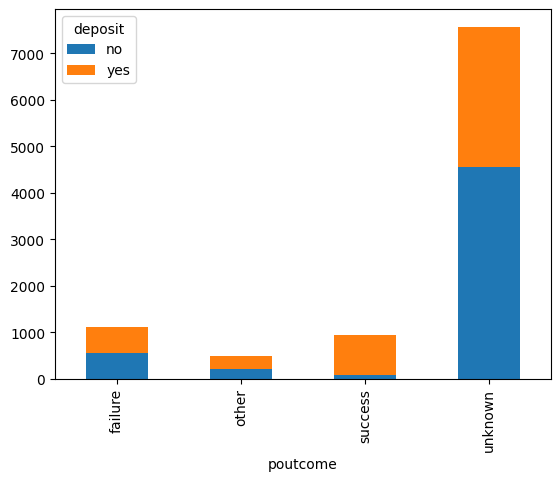

In [133]:
# Узнайте, для какого статуса предыдущей маркетинговой кампании успех в текущей превалирует над количеством неудач.
result_df = cleaned.groupby('poutcome')['deposit'].value_counts().unstack()
result_df.plot(kind= 'bar', stacked = 'True')

### Задание 7

<AxesSubplot: xlabel='month'>

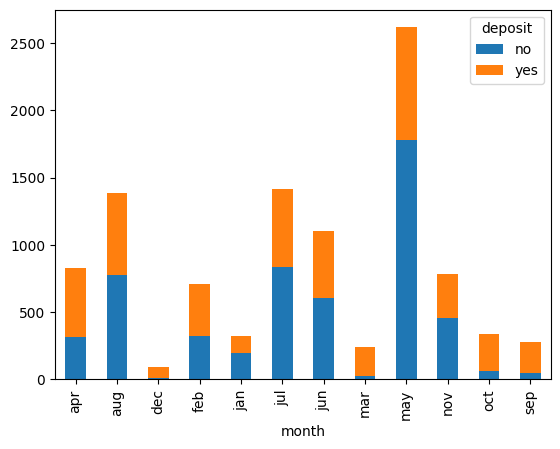

In [134]:
# узнайте, в каком месяце чаще всего отказывались от предложения открыть депозит
result_df = cleaned.groupby('month')['deposit'].value_counts().unstack()
result_df.plot(kind= 'bar', stacked = 'True')

### Задание 8

<AxesSubplot: xlabel='age_group'>

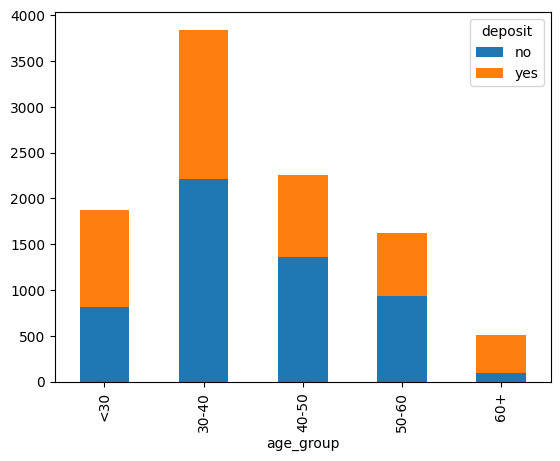

In [142]:
# создайте возрастные группы и определите, в каких группах более склонны открывать депозит, чем отказываться от предложения

cut_labels = ['<30', '30-40', '40-50', '50-60', '60+']
cut_bins = [0, 30, 40, 50, 60, 200]

cleaned['age_group'] = pd.cut(df['age'],
                       bins=cut_bins,
                       labels=cut_labels)

result_df2 = cleaned.groupby('age_group')['deposit'].value_counts().unstack()
result_df2.plot(kind= 'bar', stacked = 'True')

age_group  poutcome
<30        unknown     0.752941
           success     0.105882
           failure     0.085027
           other       0.056150
30-40      unknown     0.744664
           failure     0.126757
           success     0.079906
           other       0.048673
40-50      unknown     0.776053
           failure     0.106874
           success     0.072727
           other       0.044346
50-60      unknown     0.769846
           failure     0.105231
           success     0.088000
           other       0.036923
60+        unknown     0.584795
           success     0.259259
           failure     0.099415
           other       0.056530
Name: poutcome, dtype: float64


<AxesSubplot: xlabel='age_group'>

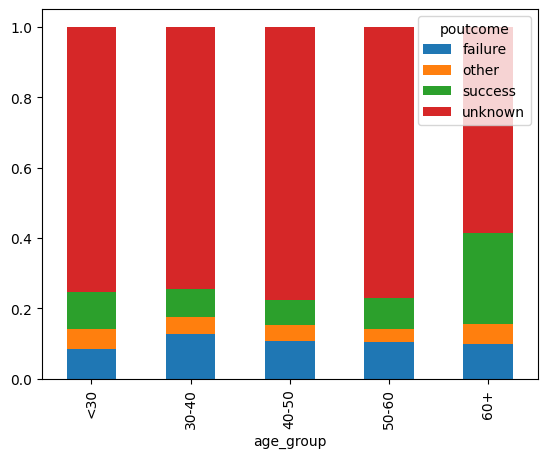

In [146]:
# Задание 3.8 Выберите из списка две возрастные группы, которые более склонны открывать депозит, чем отказываться от открытия депозита в банке после рекламного предложения.
# ОТВЕТ: группы 30-40 и 60+. Но в ответах на платформе: <30 и 60+.
print(cleaned.groupby('age_group')['poutcome'].value_counts(normalize=True))
result_df2 = cleaned.groupby('age_group')['poutcome'].value_counts(normalize=True).unstack()
result_df2.plot(kind= 'bar', stacked = 'True')

### Задания 9 и 10

In [147]:
cleaned.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,deposit,age_group
0,59,admin.,married,secondary,no,2343.0,yes,no,unknown,5,may,1042,1,-1,0,unknown,yes,50-60
1,56,admin.,married,secondary,no,45.0,no,no,unknown,5,may,1467,1,-1,0,unknown,yes,50-60
2,41,technician,married,secondary,no,1270.0,yes,no,unknown,5,may,1389,1,-1,0,unknown,yes,40-50
3,55,services,married,secondary,no,2476.0,yes,no,unknown,5,may,579,1,-1,0,unknown,yes,50-60
4,54,admin.,married,tertiary,no,184.0,no,no,unknown,5,may,673,2,-1,0,unknown,yes,50-60


marital   deposit
divorced  no          624
          yes         553
married   no         3303
          yes        2412
single    yes        1716
          no         1497
Name: deposit, dtype: int64


<AxesSubplot: xlabel='marital'>

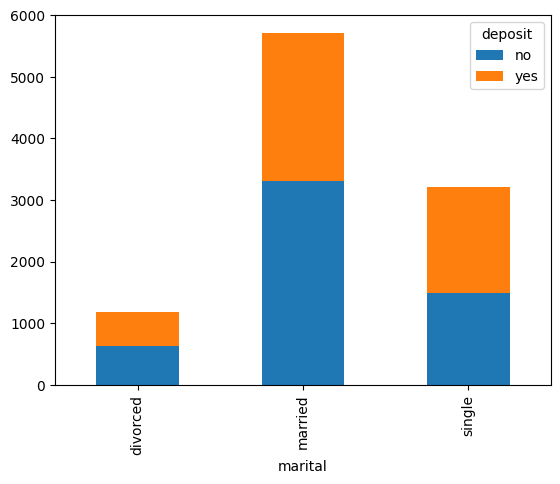

In [154]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от семейного статуса
print(cleaned.groupby('marital')['deposit'].value_counts())
result_df3 = cleaned.groupby('marital')['deposit'].value_counts().unstack()
result_df3.plot(kind= 'bar', stacked = 'True')

marital   poutcome
divorced  unknown     0.791844
          failure     0.088360
          success     0.077315
          other       0.042481
married   unknown     0.753806
          failure     0.112861
          success     0.091339
          other       0.041995
single    unknown     0.725179
          failure     0.112045
          success     0.103330
          other       0.059446
Name: poutcome, dtype: float64


<AxesSubplot: xlabel='marital'>

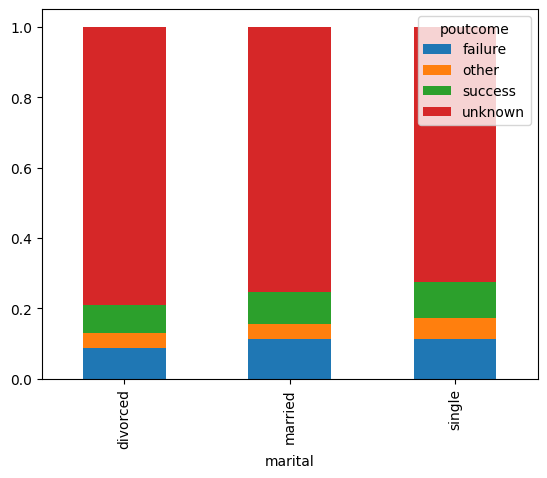

In [153]:
#Задание 3.10 При каком семейном положении есть тенденция открывать депозит, а не отказываться от его открытия? 
# Видимо в задании имеется ввиду после рекламной кампании
print(cleaned.groupby('marital')['poutcome'].value_counts(normalize=True))
result_df3 = cleaned.groupby('marital')['poutcome'].value_counts(normalize=True).unstack()
result_df3.plot(kind= 'bar', stacked = 'True')

education  poutcome
primary    unknown     0.818384
           failure     0.090437
           success     0.052632
           other       0.038547
secondary  unknown     0.750770
           failure     0.111836
           success     0.089179
           other       0.048215
tertiary   unknown     0.717505
           success     0.117938
           failure     0.114233
           other       0.050324
Name: poutcome, dtype: float64


<AxesSubplot: xlabel='education'>

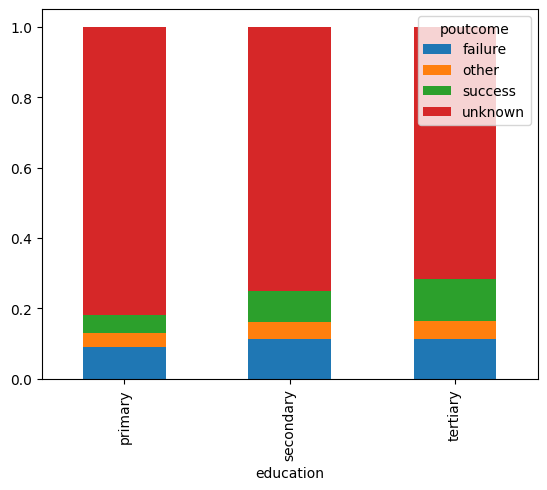

In [155]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от образования
print(cleaned.groupby('education')['poutcome'].value_counts(normalize=True))
result_df3 = cleaned.groupby('education')['poutcome'].value_counts(normalize=True).unstack()
result_df3.plot(kind= 'bar', stacked = 'True')

job            poutcome
management     unknown     1674
blue-collar    unknown     1454
technician     unknown     1250
admin.         unknown      883
services       unknown      686
retired        unknown      456
self-employed  unknown      272
management     success      261
               failure      260
entrepreneur   unknown      249
unemployed     unknown      243
housemaid      unknown      202
student        unknown      201
technician     failure      186
blue-collar    failure      179
admin.         failure      177
technician     success      133
admin.         success      121
management     other        120
retired        success      113
services       failure       92
blue-collar    other         89
               success       85
technician     other         69
admin.         other         65
retired        failure       64
student        success       62
services       success       58
unemployed     success       47
entrepreneur   failure       34
self-employed  f

<AxesSubplot: xlabel='job'>

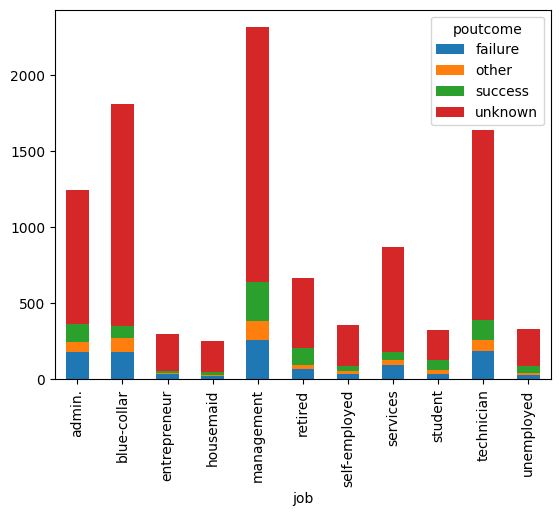

In [161]:
# постройте визуализации для открывших и неоткрывших депозит в зависимости от вида профессиональной занятости
print(cleaned.groupby('job')['poutcome'].value_counts().sort_values(ascending=False))
result_df3 = cleaned.groupby('job')['poutcome'].value_counts().unstack()
result_df3.plot(kind= 'bar', stacked = 'True')

### Задание 11

In [178]:
# постройте сводную таблицу, чтобы определить люди с каким образованием и семейным статусом наиболее многочисленны
#(если рассматривать тех, кто открыл депозит)
yes_df = cleaned[cleaned['deposit'] == 'yes']
df = yes_df.groupby(['education', 'marital'])['deposit'].count().reset_index()
df.sort_values(by= 'deposit', ascending= False).iloc[0]

# ОТВЕТ: больше всего клиентов, открывших депозит женаты/замужем и со средним образованием

education    secondary
marital        married
deposit           1289
Name: 4, dtype: object

## Часть 3: преобразование данных

### Задание 1

In [180]:
# преобразуйте уровни образования
from sklearn.preprocessing import LabelEncoder
 
labelencoder = LabelEncoder()
 
cleaned['education'] = labelencoder.fit_transform(cleaned['education'])
cleaned['education'].sum()

11995

In [184]:
cleaned['age_group'] = labelencoder.fit_transform(cleaned['age_group'])


0        2
1        2
2        1
3        2
4        2
        ..
11157    0
11158    0
11159    0
11160    1
11161    0
Name: age_group, Length: 10105, dtype: int64

### Задания 2 и 3

In [188]:
#Вычислите стандартное отклонение по преобразованной в корректный вид целевой переменной deposit. 
#Ответ округлите до трёх знаков после точки-разделителя.

cleaned['deposit'] = labelencoder.fit_transform(cleaned['deposit'])
cleaned['deposit'].std().round(3)

0.499

In [189]:
# преобразуйте бинарные переменные в представление из нулей и единиц: 'default';'housing';'loan'.
cleaned['default'] = labelencoder.fit_transform(cleaned['default'])
cleaned['housing'] = labelencoder.fit_transform(cleaned['housing'])
cleaned['loan'] = labelencoder.fit_transform(cleaned['loan'])

In [190]:
#Вычислите среднее арифметическое для каждой из получившихся переменных, сложите три результата и в качестве ответа впишите итог, 
#округлив его до трёх знаков после точки-разделителя.

round((cleaned['default'].mean()) + (cleaned['housing'].mean()) + (cleaned['loan'].mean()), 3)

0.635

### Задание 4

In [199]:
df = cleaned.copy()

In [200]:
# создайте дамми-переменные:'job';'marital';'contact';'month';'poutcome'.
df = pd.get_dummies(df, columns=['job', 'marital', 'contact', 'month', 'poutcome'])
df.info()


### Задания 5 и 6

<AxesSubplot: >

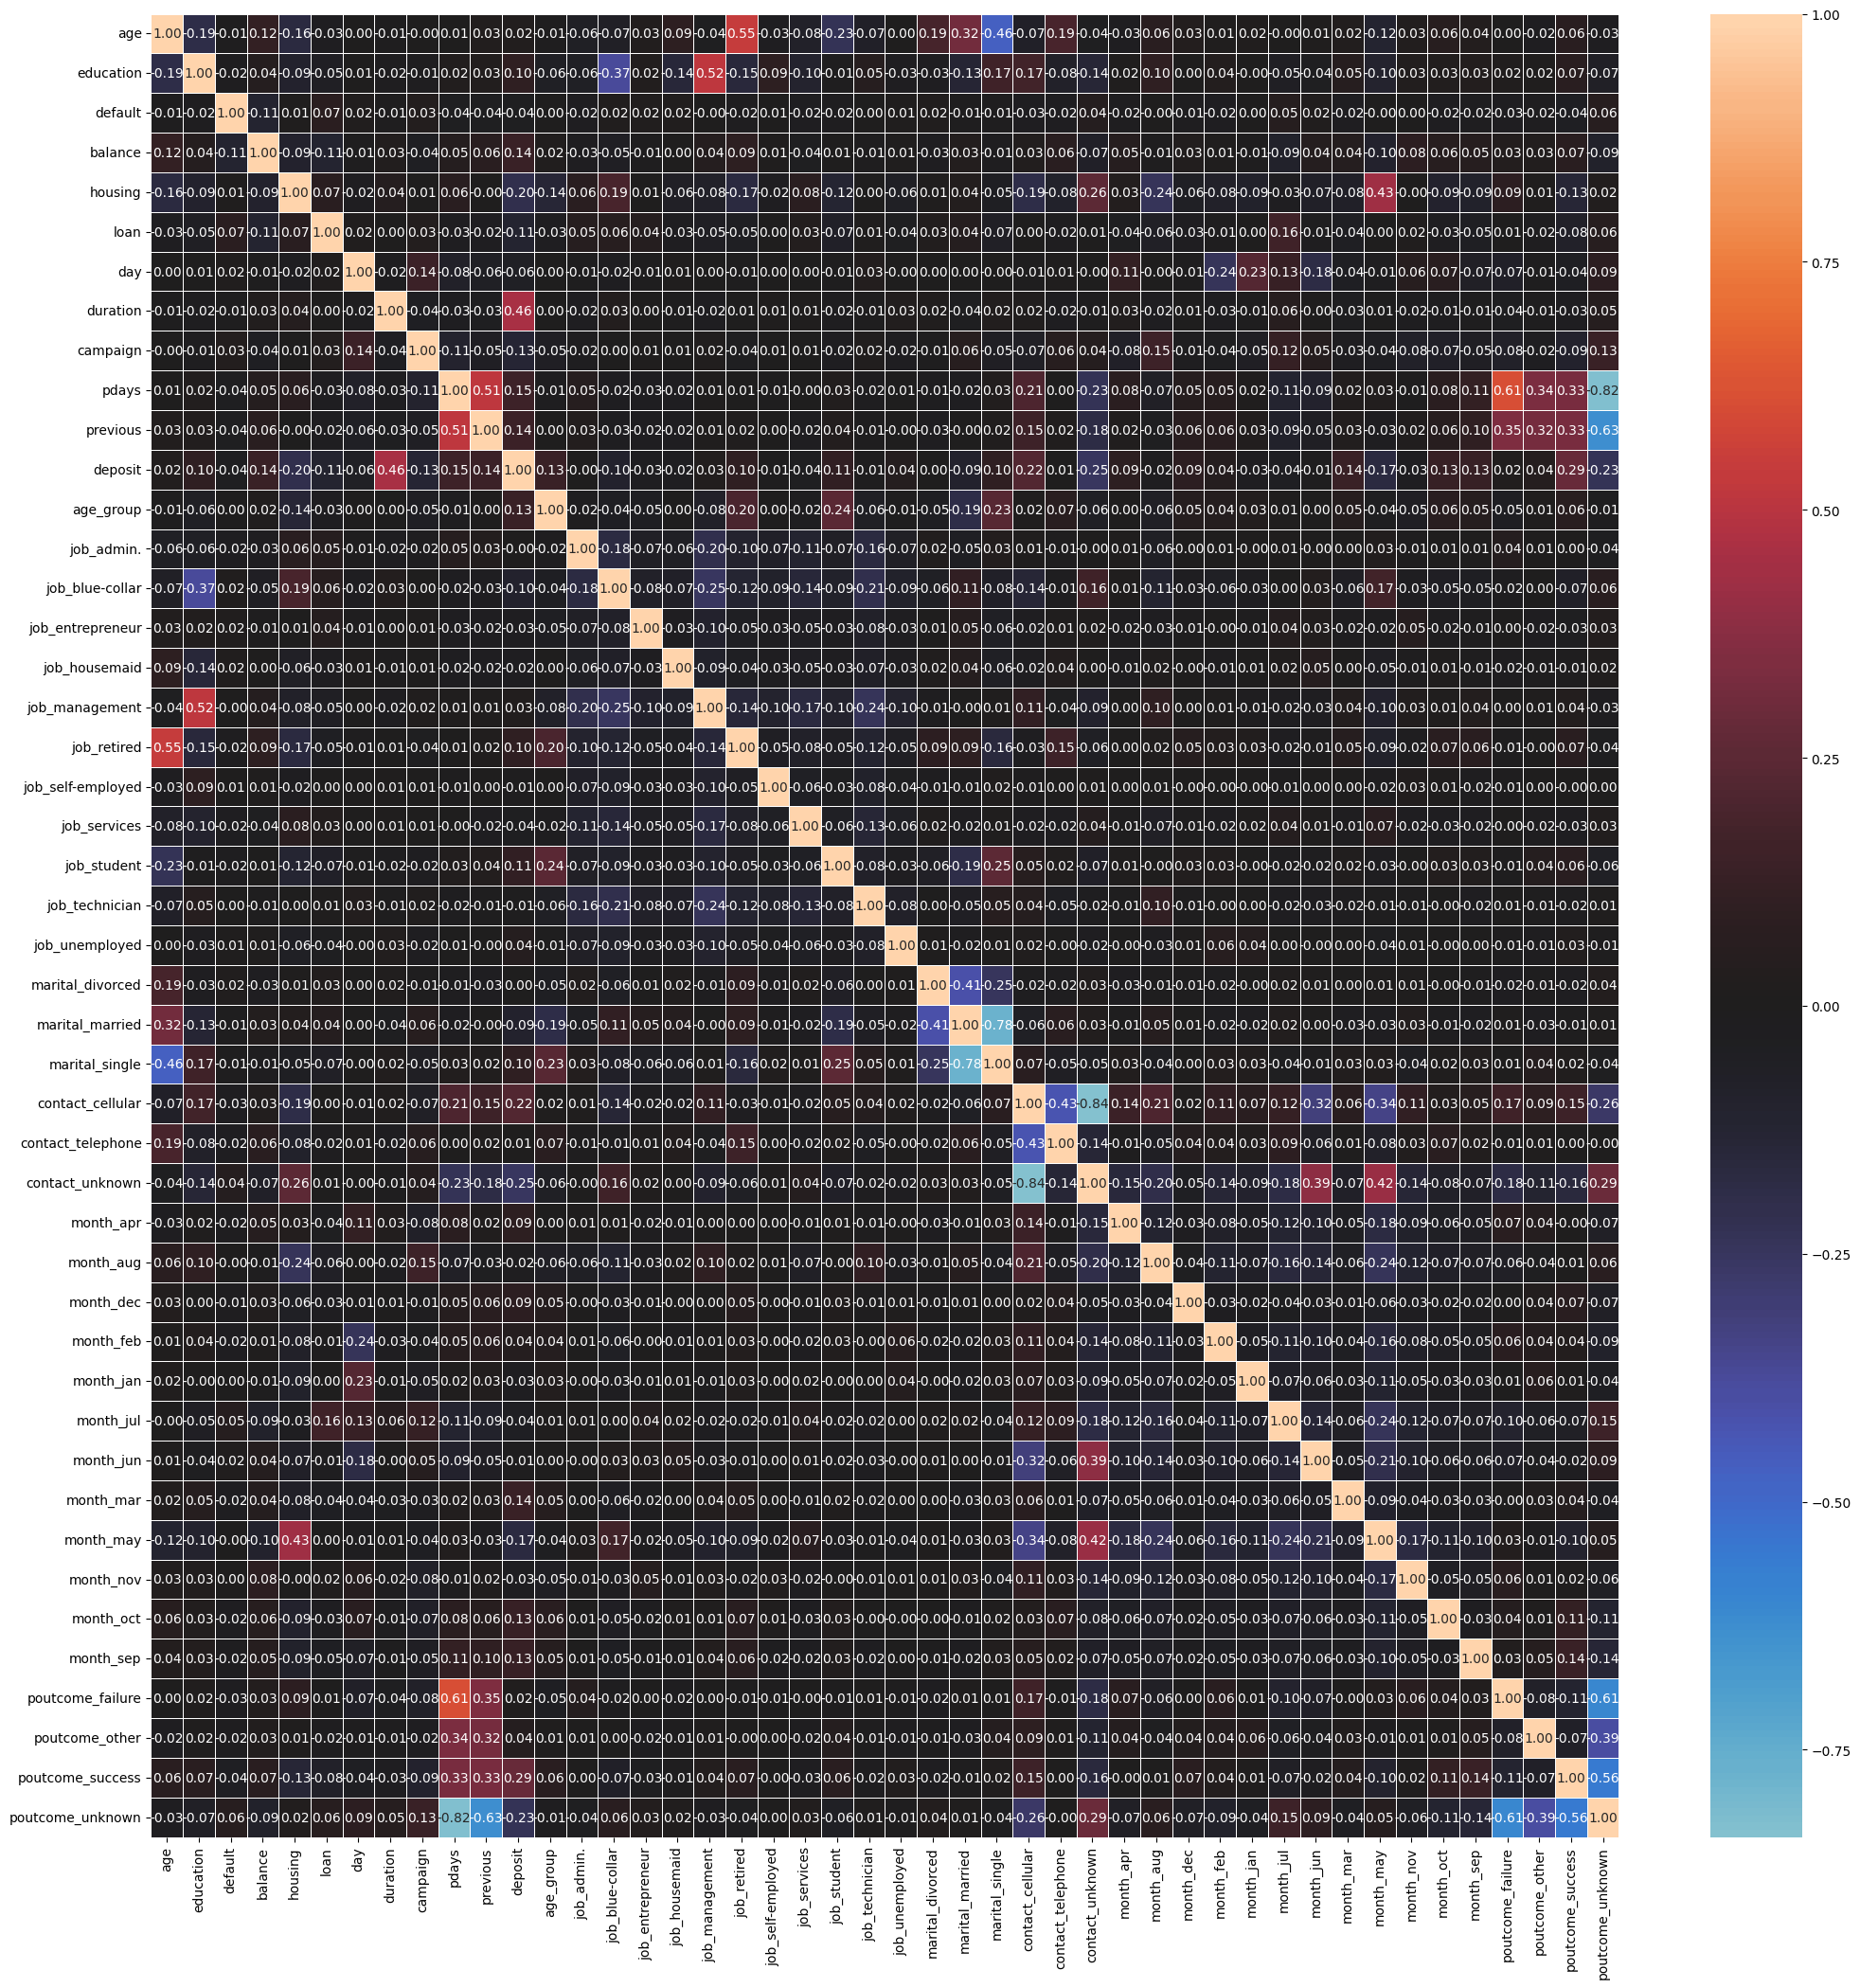

In [247]:
# постройте корреляционную матрицу и оцените данные на предмет наличия мультиколлинеарности
plt.figure(figsize=(25,25))  
sns.heatmap(df.corr(),fmt='.2f', annot=True, linewidths=.5, center=0)

In [224]:
df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[0:45]

#имеются 3 пары признаков с высокой корреляцией больше 0.7

age               age                  1.000000
contact_unknown   contact_cellular     0.837885
pdays             poutcome_unknown     0.824031
marital_married   marital_single       0.779038
previous          poutcome_unknown     0.628346
poutcome_failure  pdays                0.608719
poutcome_unknown  poutcome_failure     0.606736
poutcome_success  poutcome_unknown     0.555044
age               job_retired          0.545524
education         job_management       0.518735
pdays             previous             0.513708
marital_single    age                  0.464737
duration          deposit              0.457818
housing           month_may            0.432605
contact_cellular  contact_telephone    0.425010
contact_unknown   month_may            0.415598
marital_divorced  marital_married      0.414273
contact_unknown   month_jun            0.388312
poutcome_other    poutcome_unknown     0.386326
job_blue-collar   education            0.371796
previous          poutcome_failure     0

<function matplotlib.pyplot.show(close=None, block=None)>

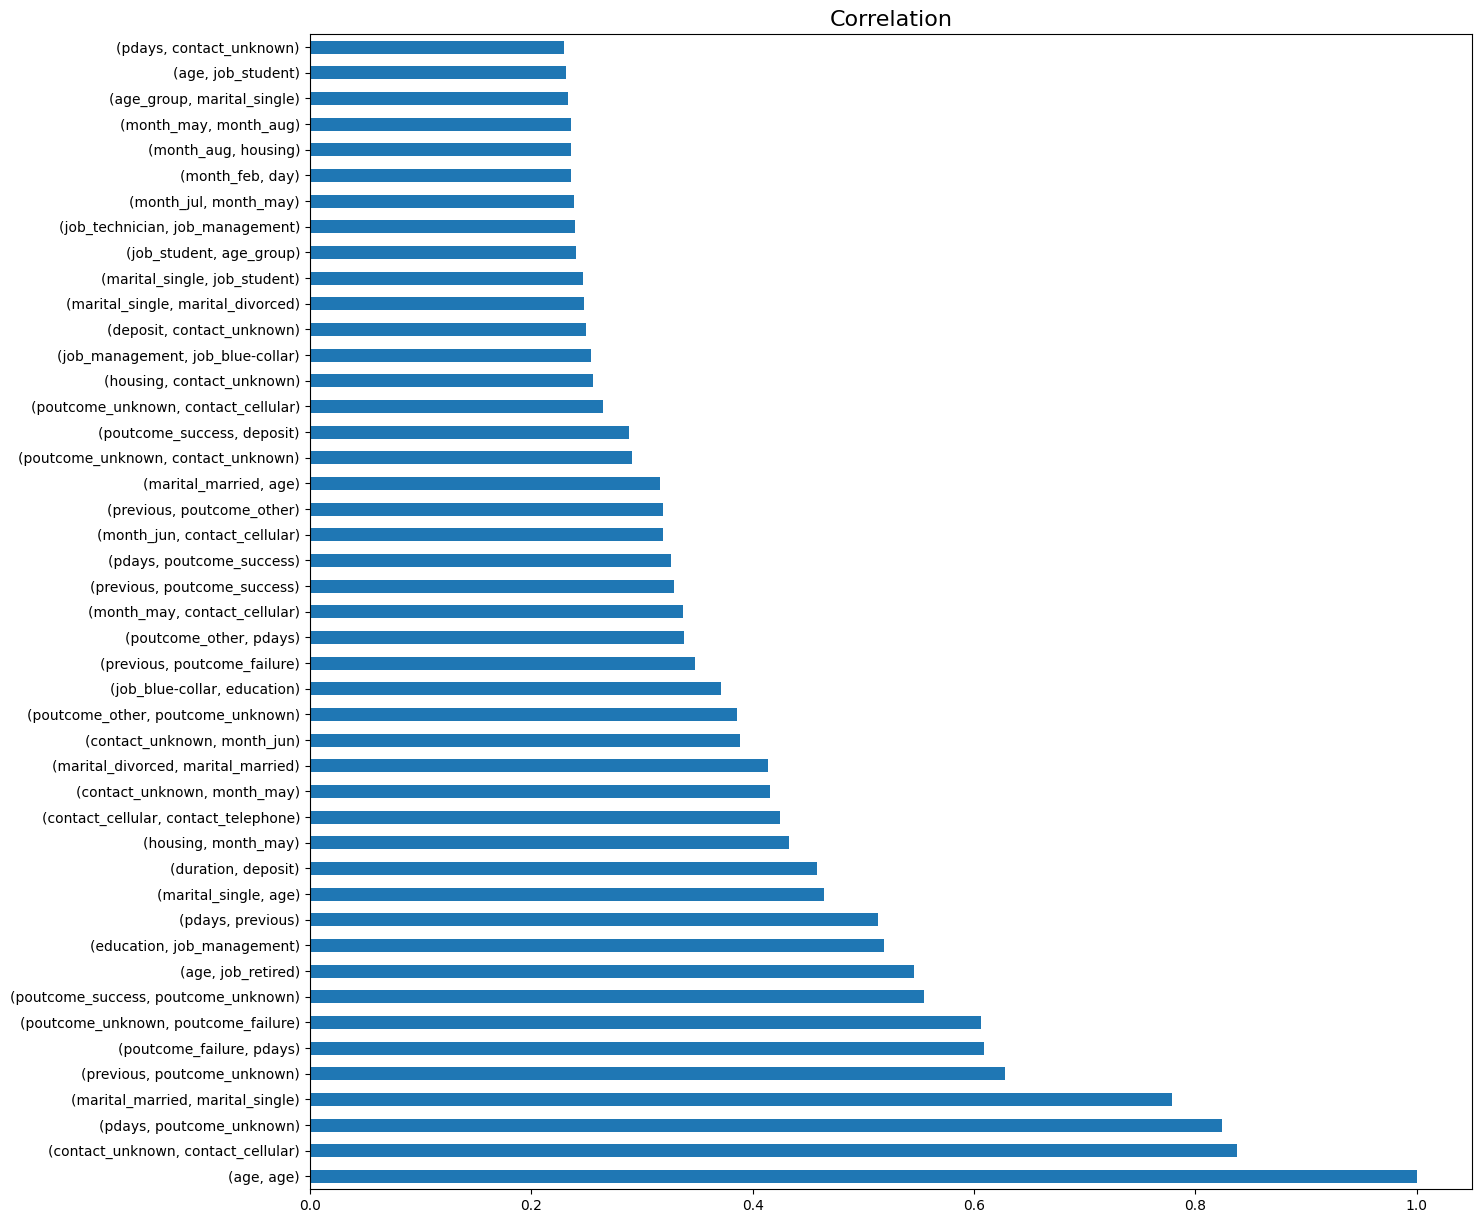

In [235]:
fig, ax = plt.subplots(figsize=(15,15))
df.corr().abs().unstack().sort_values(ascending=False).drop_duplicates()[0:45].plot.barh(ax=ax)
plt.title('Correlation', fontsize = 16)
plt.show

In [216]:
# оценим мультиколлинеарность и взаимосвязь признаков с целевой переменной.
# ОТВЕТ: мультиколлинеарности с целевой переменной не выявлено

df.corr().abs()['deposit'].sort_values(ascending=False)

deposit              1.000000
duration             0.457818
poutcome_success     0.288491
contact_unknown      0.249294
poutcome_unknown     0.228300
contact_cellular     0.223944
housing              0.200290
month_may            0.168203
pdays                0.147917
previous             0.141102
balance              0.135893
month_mar            0.135348
age_group            0.133641
campaign             0.130707
month_oct            0.130599
month_sep            0.125239
loan                 0.107240
job_student          0.105563
job_retired          0.100090
education            0.098253
marital_single       0.097005
job_blue-collar      0.095845
marital_married      0.094246
month_apr            0.092888
month_dec            0.085041
day                  0.056878
month_feb            0.044728
month_jul            0.042779
job_services         0.040433
poutcome_other       0.039319
job_unemployed       0.039196
default              0.038872
job_entrepreneur     0.032706
job_manage

<function matplotlib.pyplot.show(close=None, block=None)>

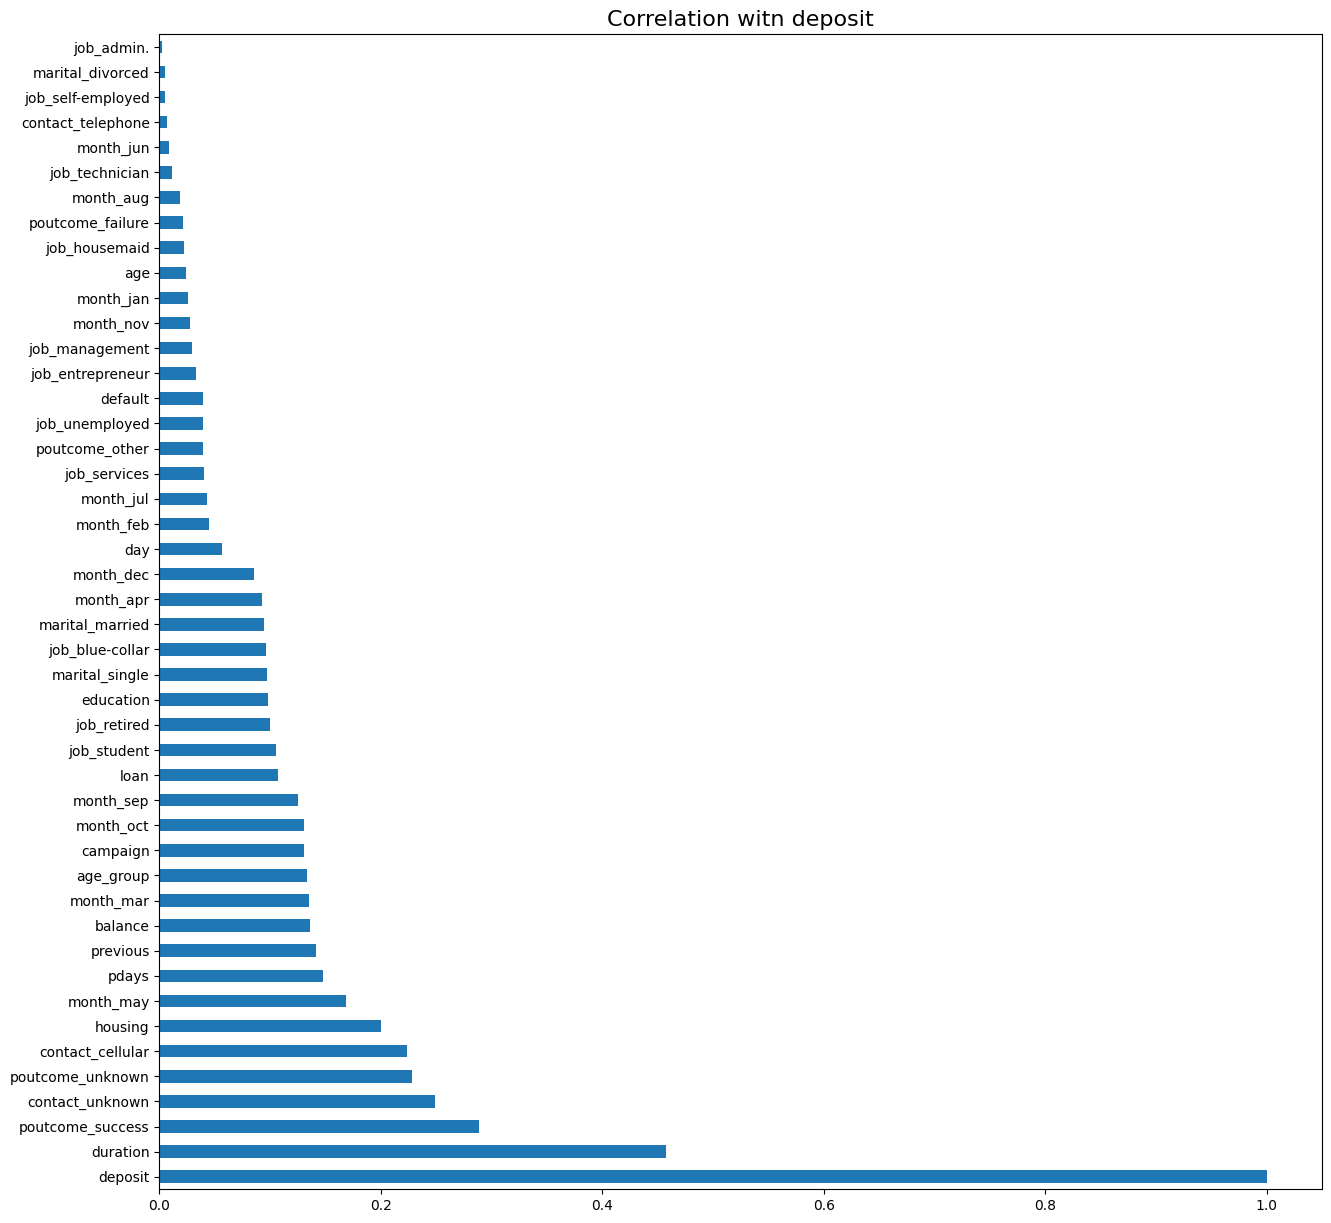

In [236]:
fig, ax = plt.subplots(figsize=(15,15))
df.corr().abs()['deposit'].sort_values(ascending=False).plot.barh(ax=ax)
plt.title('Correlation witn deposit', fontsize = 16)
plt.show

### Задания 7 и 8

In [237]:
X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

In [248]:
# рассчитайте необходимые показатели
print(f'Размер обучающей выборки {X_train.shape}')
print(f'Размер тестовой выборки {X_test.shape}')

Размер обучающей выборки (6770, 45)
Размер тестовой выборки (3335, 45)


In [251]:
#Каково среднее значение целевой переменной на тестовой выборке? Ответ округлите до двух знаков после точки-разделителя.
y_test.mean().round(2)

0.46

### Задание 9

In [263]:
# с помощью SelectKBest отберите 15 наиболее подходящих признаков
from sklearn.feature_selection import SelectKBest, f_regression
selector = SelectKBest(score_func = f_classif, k = 15)
selector.fit(X_train, y_train)
 
selector.get_feature_names_out()

array(['balance', 'housing', 'duration', 'campaign', 'pdays', 'previous',
       'age_group', 'contact_cellular', 'contact_unknown', 'month_mar',
       'month_may', 'month_oct', 'month_sep', 'poutcome_success',
       'poutcome_unknown'], dtype=object)

In [267]:
df = df[['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown', 'deposit']]

X = df.drop(['deposit'], axis=1)
y = df['deposit']
 
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state = 42, test_size = 0.33)

### Задание 10

In [268]:
# нормализуйте данные с помощью minmaxsxaler
scaler = preprocessing.MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [270]:
#Рассчитайте среднее арифметическое для первого предиктора 
#(т. е. для первого столбца матрицы) из тестовой выборки. 
#Ответ округлите до двух знаков после точки-разделителя.

X_test_scaled[:, 0].mean().round(2)

0.47

# Часть 4: Решение задачи классификации: логистическая регрессия и решающие деревья

### Задание 1

In [271]:
# обучите логистическую регрессию и рассчитайте метрики качества

#Создаем объект класса логистическая регрессия
log_reg = linear_model.LogisticRegression(solver = 'sag', random_state=42, max_iter=1000)
#Обучаем модель, минизируя logloss
log_reg.fit(X_train_scaled, y_train)
#Делаем предсказание класса
y_pred_train = log_reg.predict(X_train_scaled)
y_pred_test = log_reg.predict(X_test_scaled)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

Accuracy: 0.82
Accuracy: 0.81


### Задания 2,3,4

In [272]:
# обучите решающие деревья на настрояках в задании

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy',  
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf.predict(X_train_scaled)
y_pred_test = dt_clf.predict(X_test_scaled)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

#Переобучение

Accuracy: 1.00
Accuracy: 0.75


In [285]:
#обучите решающие деревья, настройте максимальную глубину вручную

#Создаём объект класса DecisionTreeClassifier
dt_clf = tree.DecisionTreeClassifier(
    criterion='entropy', 
    max_depth=6, 
    random_state=42
)
#Обучаем дерево решений по алгоритму CART
dt_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_pred_train = dt_clf.predict(X_train_scaled)
y_pred_test = dt_clf.predict(X_test_scaled)

#Рассчитываем accuracy
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_train, y_pred_train)))
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_pred_test)))

#Переобучение

Accuracy: 0.82
Accuracy: 0.81


### Задание 5

In [288]:
# подберите оптимальные параметры с помощью gridsearch

from sklearn.model_selection import GridSearchCV

param_grid = {'min_samples_split': [2, 5, 7, 10] ,
              'max_depth':[3,5,7], 
              }
grid_search = GridSearchCV(
    estimator=tree.DecisionTreeClassifier(
    criterion='entropy', 
    random_state=42
    ), 
    param_grid=param_grid
)  

grid_search.fit(X_train_scaled, y_train) 
print("accuracy на тестовом наборе: {:.2f}".format(grid_search.score(X_test_scaled, y_test)))
y_test_pred = grid_search.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))
print("Наилучшие значения гиперпараметров: {}".format(grid_search.best_params_))

accuracy на тестовом наборе: 0.81
f1_score на тестовом наборе: 0.80
Наилучшие значения гиперпараметров: {'max_depth': 7, 'min_samples_split': 10}


# Часть 5: Решение задачи классификации: ансамбли моделей и построение прогноза

### Задание 1

In [296]:
# обучите на ваших данных случайный лес

#Создаём объект класса случайный лес
rf_clf = ensemble.RandomForestClassifier(
    n_estimators = 100,
    criterion = 'gini',
    min_samples_leaf = 5,
    max_depth = 10,
    random_state = 42 #генератор случайных чисел
)
#Обучаем модель 
rf_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_test_pred = rf_clf.predict(X_test_scaled)
#Выводим отчёт о метриках
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('Recall  на тестовом наборе: {:.2f}'.format(metrics.recall_score(y_test, y_test_pred)))

Accuracy: 0.83
Recall  на тестовом наборе: 0.83


In [297]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задания 2 и 3

In [298]:
# используйте для классификации градиентный бустинг и сравните качество со случайным лесом

gb_clf = ensemble.GradientBoostingClassifier(
    learning_rate = 0.05,
    n_estimators = 300,
    min_samples_leaf = 5,
    max_depth = 5,
    random_state = 42 #генератор случайных чисел
)
#Обучаем модель 
gb_clf.fit(X_train_scaled, y_train)

#Делаем предсказание класса
y_test_pred = gb_clf.predict(X_test_scaled)
#Выводим отчёт о метриках
print('Accuracy: {:.2f}'.format(metrics.accuracy_score(y_test, y_test_pred)))
print('F1 на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

Accuracy: 0.83
F1 на тестовом наборе: 0.82


In [299]:
print(metrics.classification_report(y_test, y_test_pred))

              precision    recall  f1-score   support

           0       0.85      0.82      0.84      1790
           1       0.80      0.83      0.82      1545

    accuracy                           0.83      3335
   macro avg       0.83      0.83      0.83      3335
weighted avg       0.83      0.83      0.83      3335



### Задание 4

In [301]:
# объедините уже известные вам алгоритмы с помощью стекинга 

estimator = [
    ('dt_clf', tree.DecisionTreeClassifier(
        criterion='entropy',
        min_samples_leaf=5,
        max_depth=6,
        random_state=42
        )
    ),
    ('log_reg', linear_model.LogisticRegression(
        solver = 'sag', random_state=42
        )
    ),
    ('gb_clf', ensemble.GradientBoostingClassifier(
        learning_rate = 0.05,
        n_estimators = 300,
        min_samples_leaf = 5,
        max_depth = 5,
        random_state = 42 #генератор случайных чисел
        )
     )
]

stack = ensemble.StackingClassifier(
    estimators = estimator,
    final_estimator=linear_model.LogisticRegression(random_state=42)
)
stack.fit(X_train_scaled, y_train)

y_test_pred = stack.predict(X_test_scaled)

print('precision на тестовом наборе: {:.2f}'.format(metrics.precision_score(y_test, y_test_pred)))

print(metrics.classification_report(y_test, y_test_pred))

precision на тестовом наборе: 0.81
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1790
           1       0.81      0.81      0.81      1545

    accuracy                           0.82      3335
   macro avg       0.82      0.82      0.82      3335
weighted avg       0.82      0.82      0.82      3335



### Задание 5

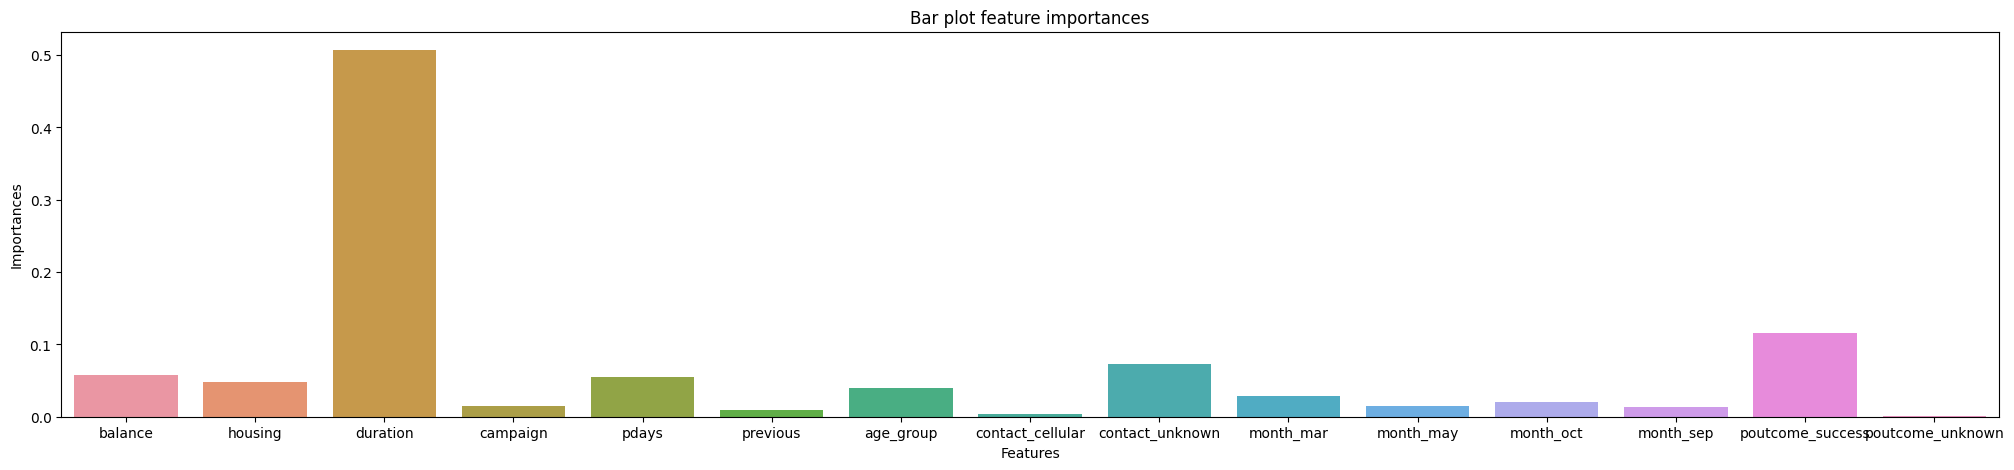

In [315]:
# давайте выберем три признака, дающих наибольший вклад.
# 
columns = ['balance', 'housing', 'duration', 'campaign', 'pdays', 
         'previous', 'age_group', 'contact_cellular', 'contact_unknown',
         'month_mar', 'month_may', 'month_oct', 'month_sep', 'poutcome_success', 'poutcome_unknown']

data = pd.DataFrame(X_train_scaled, columns = columns, )
data.head(5)

fig, ax = plt.subplots(figsize=(25, 5)) #фигура + координатная плоскость
feature = data.columns #признаки
feature_importances = gb_clf.feature_importances_ #важность признаков
#Строим столбчатую диаграмму
sns.barplot(x=feature, y=feature_importances, ax=ax);
#Добавляем подпись графику, осям абцисс и ординат
ax.set_title('Bar plot feature importances')
ax.set_xlabel('Features')
ax.set_ylabel('Importances');

### Задания 6,7,8

In [316]:
# реализуйте оптимизацию гиперпараметров с помощью Optuna

import optuna

print("Версия Optuna: {}".format(optuna.__version__))

Версия Optuna: 3.3.0


In [317]:
def optuna_rf(trial):
  # задаем пространства поиска гиперпараметров
  n_estimators = trial.suggest_int('n_estimators', 100, 200, 1);
  max_depth = trial.suggest_int('max_depth', 10, 30, 1);
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 10, 1)

  # создаем модель
  model = ensemble.RandomForestClassifier(n_estimators=n_estimators,
                                          max_depth=max_depth,
                                          min_samples_leaf=min_samples_leaf,
                                          random_state=42)
  # обучаем модель
  model.fit(X_train_scaled, y_train)
  score = metrics.f1_score(y_train, model.predict(X_train_scaled))

  return score
  
  # cоздаем объект исследования
# можем напрямую указать, что нам необходимо максимизировать метрику direction="maximize"
study = optuna.create_study(study_name="RandomForestClassifier", direction="maximize")
# ищем лучшую комбинацию гиперпараметров n_trials раз
study.optimize(optuna_rf, n_trials=20)

# выводим результаты на обучающей выборке
print("Наилучшие значения гиперпараметров {}".format(study.best_params))
print("f1_score на обучающем наборе: {:.2f}".format(study.best_value))

# рассчитаем точность для тестовой выборки
model = ensemble.RandomForestClassifier(**study.best_params,random_state=42, )
model.fit(X_train_scaled, y_train)
y_train_pred = model.predict(X_train_scaled)
print("accuracy на тестовом наборе: {:.2f}".format(model.score(X_test_scaled, y_test)))
y_test_pred = model.predict(X_test_scaled)
print('f1_score на тестовом наборе: {:.2f}'.format(metrics.f1_score(y_test, y_test_pred)))

study.optimize(optuna_rf, n_trials=10)

#результат не улучшился

[I 2023-08-30 16:39:44,166] A new study created in memory with name: RandomForestClassifier
[I 2023-08-30 16:39:46,999] Trial 0 finished with value: 0.8451410658307211 and parameters: {'n_estimators': 145, 'max_depth': 16, 'min_samples_leaf': 10}. Best is trial 0 with value: 0.8451410658307211.
[I 2023-08-30 16:39:48,684] Trial 1 finished with value: 0.8819934179595674 and parameters: {'n_estimators': 134, 'max_depth': 13, 'min_samples_leaf': 2}. Best is trial 1 with value: 0.8819934179595674.
[I 2023-08-30 16:39:50,816] Trial 2 finished with value: 0.89073262366938 and parameters: {'n_estimators': 155, 'max_depth': 21, 'min_samples_leaf': 3}. Best is trial 2 with value: 0.89073262366938.
[I 2023-08-30 16:39:51,872] Trial 3 finished with value: 0.8505388099328439 and parameters: {'n_estimators': 113, 'max_depth': 29, 'min_samples_leaf': 9}. Best is trial 2 with value: 0.89073262366938.
[I 2023-08-30 16:39:53,764] Trial 4 finished with value: 0.8462986198243413 and parameters: {'n_estim

Наилучшие значения гиперпараметров {'n_estimators': 189, 'max_depth': 24, 'min_samples_leaf': 2}
f1_score на обучающем наборе: 0.92
accuracy на тестовом наборе: 0.83
f1_score на тестовом наборе: 0.82


[I 2023-08-30 16:40:23,174] Trial 20 finished with value: 0.8801000468969828 and parameters: {'n_estimators': 167, 'max_depth': 25, 'min_samples_leaf': 4}. Best is trial 19 with value: 0.923173605655931.
[I 2023-08-30 16:40:25,583] Trial 21 finished with value: 0.9225462527438067 and parameters: {'n_estimators': 190, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.923173605655931.
[I 2023-08-30 16:40:28,171] Trial 22 finished with value: 0.9220392156862746 and parameters: {'n_estimators': 198, 'max_depth': 23, 'min_samples_leaf': 2}. Best is trial 19 with value: 0.923173605655931.
[I 2023-08-30 16:40:30,206] Trial 23 finished with value: 0.8942022190967339 and parameters: {'n_estimators': 200, 'max_depth': 27, 'min_samples_leaf': 3}. Best is trial 19 with value: 0.923173605655931.
[I 2023-08-30 16:40:32,198] Trial 24 finished with value: 0.8794879800187324 and parameters: {'n_estimators': 184, 'max_depth': 23, 'min_samples_leaf': 4}. Best is trial 19 with value: